In [1]:
import numpy as np
import sys
import time
import halotools
import matplotlib.pyplot as plt

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog

model = PrebuiltHodModelFactory('zheng07') # Zheng HOD

# set all Zheng parameters to fiducial values from Fermilab HOD paper
model.param_dict['logMmin'] = 12.36
model.param_dict['logM1'] = 13.69
model.param_dict['sigma_logM'] = 0.32
model.param_dict['alpha'] = 1.28

bolshoi_z0 = CachedHaloCatalog() # bolshoi z=0 rockstar halos are default catalog
halos = bolshoi_z0.halo_table # table of bolshoi halos and their properties
particles = bolshoi_z0.ptcl_table # table of ~10^6 bolshoi particles and their properties

In [2]:
# display all halo, particle properties available in bolshoi data
print("Bolshoi halo properties: \n", halos.keys(), "\n")
print("Bolshoi particle properties: \n", particles.keys())

Bolshoi halo properties: 
 ['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_xoff', 'halo_spin', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo'] 

Bolshoi particle properties: 
 ['vx', 'ptcl_id', 'vy', 'y', 'x', 'vz', 'z']


In [3]:
halo_m200b = np.array(halos['halo_m200b']) # numpy array of 200x-background masses (halo def'n in Fermi HOD paper)
halo_x_array = np.array(halos['halo_x']) # numpy array of halo x positions (0-250 Mpc)
halo_y_array = np.array(halos['halo_y']) # same for y positions
halo_z_array = np.array(halos['halo_z']) # same for z positions

# N.B. will use flattened data, so only need 2 of 3 arrays at a time
ptcl_x_array = np.array(particles['x']) # numpy array of particle x positions (0-250 Mpc)
ptcl_y_array = np.array(particles['y']) # same for y positions
ptcl_z_array = np.array(particles['z']) # same for y positions

In [5]:
# check 5 least/most massive halos in table
print(np.sort(halo_m200b)[:5])
print(np.sort(halo_m200b)[-5:])

[2.7259e+08 4.0889e+08 4.0889e+08 4.0889e+08 4.0889e+08]
[5.6251e+14 6.1415e+14 6.7212e+14 1.0791e+15 1.2711e+15]


In [6]:
print('total particles in sample:', len(ptcl_x_array))
print('total halos in simulation:', len(halo_m200b))

total particles in sample: 1000000
total halos in simulation: 1367493


In [7]:
# create list of cylinder positions

box_length = 250 # linear size of simulation in Mpc
cyl_radius = 5.0  # cylinder radius in Mpc
cyl_spacing = 2.5 # spacing btw cyl centers in Mpc -- ***choose s.t. an integer multiple fits in box_length

grid_dim = int(np.floor(box_length/cyl_spacing)) # number of cylinders along each axis of grid

list_cyl_centers = []

# populate cyl_centers with 2-element lists of x position, y position for cylinder centers

coord_array = np.linspace(0, box_length - cyl_spacing, grid_dim) # cyl center locations, both x and y

for xpos in coord_array:
    temp_row = []
    for ypos in coord_array:
        temp_row.append([xpos, ypos])
    
    list_cyl_centers.append(temp_row)

cyl_centers = np.array(list_cyl_centers)

In [8]:
# function which calculates distance between points specified by 2-element lists acoords, bcoords
# implements periodic boundary conditions in both x and y directions, box dimensions given by <size>
def dist(acoords, bcoords, size):
    x_larger = max(acoords[0], bcoords[0]) # greater of the two x coordinates
    x_smaller = min(acoords[0], bcoords[0]) # lesser x coordinate
    xsep_direct = x_larger - x_smaller # direct x separation (within box)
    xsep_around = (size - x_larger) + x_smaller # around-the-corner x separation (across boundary)
    xsep_min = min(xsep_direct, xsep_around) # use the lesser of the two x separations
    
    y_larger = max(acoords[1], bcoords[1]) # greater of the two y coordinates
    y_smaller = min(acoords[1], bcoords[1]) # lesser y coordinate
    ysep_direct = y_larger - y_smaller # direct y separation (within box)
    ysep_around = (size - y_larger) + y_smaller # around-the-corner y separation (across boundary)
    ysep_min = min(ysep_direct, ysep_around) # use the lesser of the two y separations
    
    my_dist = np.sqrt(xsep_min**2 + ysep_min**2)
    return my_dist

# function which returns True if particle is in cylinder with specified center and radius
def in_cyl(ptcl_coords, cyl_coords, size, radius):
    is_in_cylinder = dist(ptcl_coords, cyl_coords, size) <= radius
    return is_in_cylinder

In [9]:
cyl_ptcl_counts = np.zeros([grid_dim, grid_dim]) # list to hold num of particles for each cyl
n_ptcl = len(ptcl_x_array)
n_run_ptcl = n_ptcl # round(n_ptcl/10) # for testing, only run the first n_run_ptcl particles in the list


print("Particles:")
start_time = time.process_time()

for ptcl_index in range(n_run_ptcl):
    ptcl_coords = [ptcl_x_array[ptcl_index], ptcl_y_array[ptcl_index]] # flattening along z direction
    
    cyl_xindex = int(round(ptcl_coords[0]/box_length*grid_dim)) # convert x position to nearest cylinder x index
    cyl_yindex = int(round(ptcl_coords[1]/box_length*grid_dim))

    cyl_span = int(np.ceil(cyl_radius/cyl_spacing) + 1) # number of indices to search left/right/up/down from closest center

    cyl_xsearch = []
    cyl_ysearch = []
    
    for i in range(cyl_xindex - cyl_span, cyl_xindex + cyl_span + 1):
        cyl_xsearch.append((grid_dim + i)%grid_dim)

    for i in range(cyl_yindex - cyl_span, cyl_yindex + cyl_span + 1):
        cyl_ysearch.append((grid_dim + i)%grid_dim)
        
    
    for x_index in cyl_xsearch:
        for y_index in cyl_ysearch:
            if in_cyl(ptcl_coords, cyl_centers[x_index, y_index], box_length, cyl_radius):
                cyl_ptcl_counts[x_index, y_index] += 1
        
    
    if (ptcl_index+1)%1000 == 0:
        sys.stdout.write("\r" + f"{round((ptcl_index+1)/n_run_ptcl*100,1)}% complete")
        sys.stdout.flush()

run_elapsed = time.process_time() - start_time
run_mins, run_secs = divmod(run_elapsed, 60)
run_time = '{:02d}:{:02d}'.format(round(run_mins), round(run_secs))
print("\n" + f"runtime: {run_time} s")

Particles:
100.0% complete
runtime: 03:33 s


In [10]:
# assign galaxies to cylinders

cyl_galx_counts = np.zeros([grid_dim, grid_dim]) # list to hold num of galaxies for each cyl
n_halo = len(halo_m200b)
n_run_halo = n_halo # round(n_halo/10) # for testing, run only the first n_run_halo halos in the list

halo_cen = model.mean_occupation_centrals(prim_haloprop = halo_m200b) # Zheng mean central galaxies in halo
halo_sat = model.mean_occupation_satellites(prim_haloprop = halo_m200b) # Zheng mean satellites in halo
halo_ngal_mean = [(halo_cen[i] + halo_sat[i]) for i in range(n_run_halo)] # mean total galaxies in halo
halo_ngal_draws = [np.random.poisson(halo_ngal_mean[j]) for j in range(n_run_halo)] # draw galaxies for halos

print("Galaxies:")
start_time = time.process_time()

for halo_index in range(n_run_halo):
    halo_coords = [halo_x_array[halo_index], halo_y_array[halo_index]] # flattening along z direction
    
    cyl_xindex = int(round(halo_coords[0]/box_length*grid_dim)) # convert x position to nearest cylinder x index
    cyl_yindex = int(round(halo_coords[1]/box_length*grid_dim))
    
    cyl_span = int(np.ceil(cyl_radius/cyl_spacing) + 1) # number of indices to search left/right/up/down from closest center
    
    cyl_xsearch = []
    cyl_ysearch = []
    
    for i in range(cyl_xindex - cyl_span, cyl_xindex + cyl_span + 1):
        cyl_xsearch.append((grid_dim + i)%grid_dim)

    for i in range(cyl_yindex - cyl_span, cyl_yindex + cyl_span + 1):
        cyl_ysearch.append((grid_dim + i)%grid_dim)
        
    for x_index in cyl_xsearch:
        for y_index in cyl_ysearch:
            if in_cyl(halo_coords, cyl_centers[x_index, y_index], box_length, cyl_radius):
                cyl_galx_counts[x_index, y_index] += halo_ngal_draws[halo_index]
    
    if (halo_index+1)%100 == 0:
        sys.stdout.write("\r" + f"{round((halo_index+1)/n_run_halo*100,1)}% complete")
        sys.stdout.flush()

run_elapsed = time.process_time() - start_time
run_mins, run_secs = divmod(run_elapsed, 60)
run_time = '{:02d}:{:02d}'.format(round(run_mins), round(run_secs))
print("\n" + f"runtime: {run_time} s")

Galaxies:
100.0% complete
runtime: 09:22 s


In [11]:
# save particle, galaxy counts to csv
np.savetxt('cyl_ptcl_counts.csv', cyl_ptcl_counts, delimiter=',')
np.savetxt('cyl_galx_counts.csv', cyl_galx_counts, delimiter=',')

In [12]:
# load particle, galaxy counts from csv
test_load_ptcl = np.loadtxt('cyl_ptcl_counts.csv', delimiter=',')
test_load_galx = np.loadtxt('cyl_galx_counts.csv', delimiter=',')

In [13]:
# check saved data versus source arrays
print(np.sum((test_load_ptcl - cyl_ptcl_counts)**2))
print(np.sum((test_load_galx - cyl_galx_counts)**2))

0.0
0.0


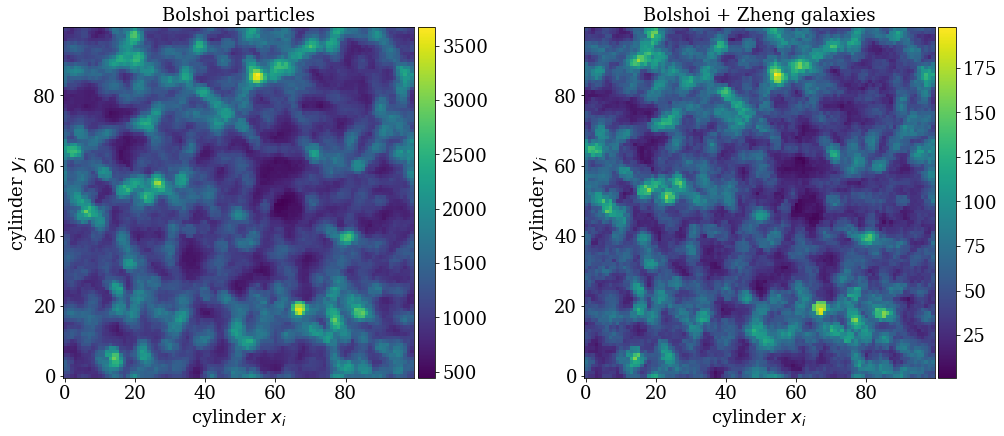

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({
    'lines.linewidth':2.0,
    'font.family':'serif',
    'font.size': 18,
    'legend.fontsize':16,
    'legend.frameon':False})

# Plot
fig = plt.figure(figsize=(16, 12))

ptcl_subplot = fig.add_subplot(1, 2, 1)
ptcl_subplot.set_title('Bolshoi particles', fontsize = 18)
ptcl_subplot.set_xlabel('cylinder $x_i$')
ptcl_subplot.set_ylabel('cylinder $y_i$')
im_ptcl = ptcl_subplot.imshow(test_load_ptcl, origin = 'lower', interpolation = 'None')

# make colorbar
divider1 = make_axes_locatable(ptcl_subplot)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_ptcl, cax=cax1, orientation='vertical')



galx_subplot = fig.add_subplot(1, 2, 2)
galx_subplot.set_title('Bolshoi + Zheng galaxies', fontsize = 18)
galx_subplot.set_xlabel('cylinder $x_i$')
galx_subplot.set_ylabel('cylinder $y_i$')
im_galx = galx_subplot.imshow(test_load_galx, origin = 'lower', interpolation = 'None')

# make colorbar
divider2 = make_axes_locatable(galx_subplot)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_galx, cax=cax2, orientation='vertical')

fig.patch.set_facecolor('white')
fig.subplots_adjust(wspace=0.4, hspace=0.5)

plt.show()